In [26]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal


class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, batch_size=128,
                 epsilon=0.5, epoch_n=50, pi_lr=1e-3, v_lr=5e-3):

        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        pi_output = self.pi_model(torch.FloatTensor(state))
        mean = pi_output[..., :self.action_dim]
        log_std = pi_output[..., self.action_dim:]
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        action = dist.sample()
        return action.numpy()

    def fit(self, states, actions, rewards, dones):

        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        pi_output = self.pi_model(states)
        mean = pi_output[:, :self.action_dim]  # Get the first half of the output for mean
        log_std = pi_output[:, self.action_dim:]  # Get the second half of the output for log_std
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        old_log_probs = dist.log_prob(actions).detach().sum(dim=1, keepdim=True)

        for epoch in range(self.epoch_n):
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                b_advantage = b_returns.detach() - self.v_model(b_states)

                pi_output = self.pi_model(b_states)
                b_mean = pi_output[:, :self.action_dim]
                b_log_std = pi_output[:, self.action_dim:]
                b_std = torch.exp(b_log_std)
                b_dist = Normal(b_mean, b_std)
                b_new_log_probs = b_dist.log_prob(b_actions).sum(dim=1, keepdim=True)

                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()

                v_loss = torch.mean(b_advantage ** 2)

                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [34]:
env = gym.make('LunarLander-v2', continuous=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO(state_dim, action_dim, gamma=0.99)

episode_n = 10
trajectory_n = 200

total_rewards_mult_action = []
super_buffer = []
for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(500):
            states.append(state)

            action = agent.get_action(state)
            actions.append(action)

            state, reward, done, _ = env.step(action * 2)
            if(reward>50):
                print("WE DID IT")
            rewards.append(reward)
            dones.append(done)

            if done:
                break

            total_reward += reward
            if reward > 50:
                super_buffer.append(t)
        total_rewards_mult_action.append(total_reward)

    agent.fit(states, actions, rewards, dones)

/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT
WE DID IT


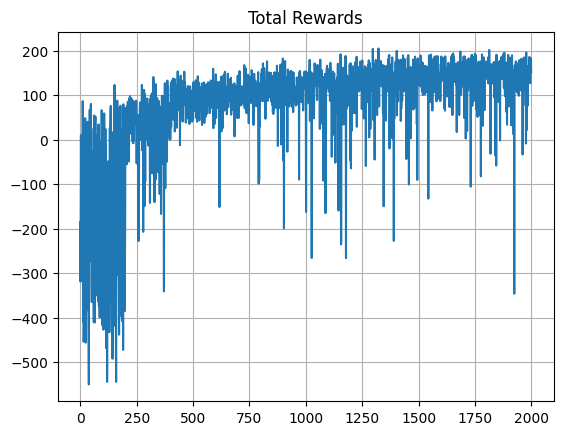

In [35]:
plt.plot(total_rewards_mult_action)
plt.title('Total Rewards')
plt.grid()
plt.show()

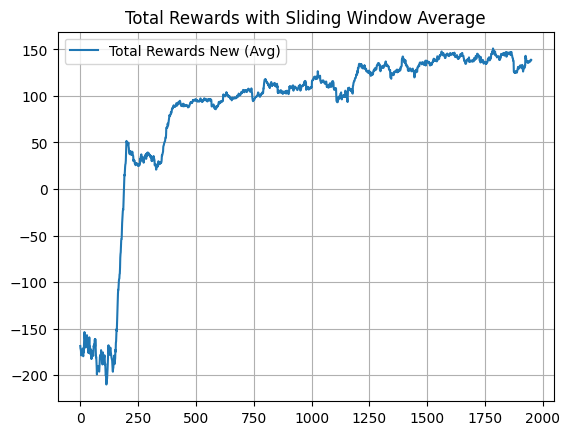

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def sliding_window_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size


window_size = 50

avg_total_rewards_new = sliding_window_average(total_rewards_mult_action, window_size)

plt.plot(avg_total_rewards_new, label='Total Rewards New (Avg)')
plt.title('Total Rewards with Sliding Window Average')
plt.grid()
plt.legend()
plt.show()
